[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# The Extended Kalman Filter

In [1]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style
load_style()

At this point in the book we have developed the theory for the linear Kalman filter. Then, in the last two chapters we broached the topic of using Kalman filters for nonlinear problems. In this chapter we will learn the Extended Kalman filter (EKF). The EKF handles nonlinearity by linearizing the system at the point of the current estimate, and then the linear Kalman filter is used to filter this linearized system. It was one of the very first techniques used for nonlinear problems, and it remains the most common technique. 

The EKF provides significant mathematical challenges to the designer of the filter; this is the most challenging chapter of the book. To be honest, I do everything I can to avoid the EKF in favor of other techniques that have been developed to filter nonlinear problems. However, the topic is unavoidable; all classic papers and a majority of current papers in the field use the EKF. Even if you do not use the EKF in your own work you will need to be familiar with the topic to be able to read the literature. 

## Linearizing a System

Consider the function $f(x)=x^2−2x$. It could be our measurement function or process model. We want a linear approximation of this function to use in the Kalman filter.  There is no linear function that gives a close approximation of this function for all values of $x$. However, during each epoch (update) of the Kalman filter we know its current state, so if we linearize the function at that value we will have a close approximation in that location. For example, suppose our current state is $x=1.5$. What would be a good linearization for this function?

We can use any linear function that passes through the curve at (1.5,-0.75). For example, consider using f(x)=8x−12.75 as the linearization, as in the plot below.

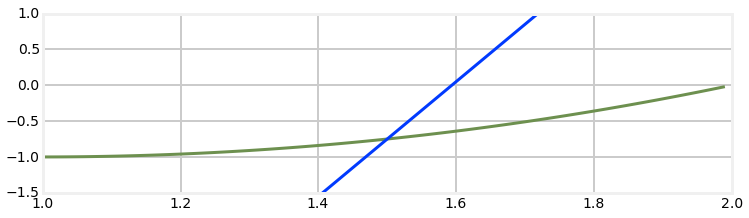

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xs =  np.arange(0, 2, 0.01)
ys = [x**2 - 2*x for x in xs]

def y(x): 
    return 8*x - 12.75

plt.plot(xs, ys)
plt.plot([1.25, 1.75], [y(1.25), y(1.75)])
plt.xlim(1, 2)
plt.ylim([-1.5, 1]);

This is not a good linearization for $f(x)$. It is exact for $x=1.5$, but quickly diverges when $x$ varies by a small amount.

A much better approach is to use the slope of the function at the evaluation point as the linearization. We find the slope by taking the first derivative of the function:

$$f(x) = x^2 -2x \\
\frac{df}{dx} = 2x - 2$$ 
 
Let's plot that.

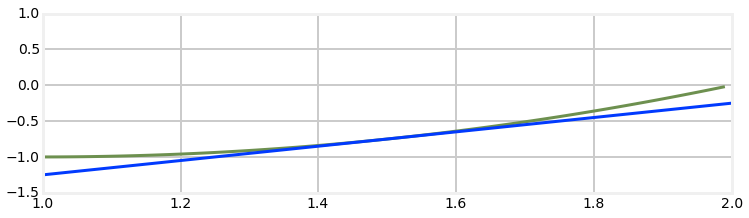

In [3]:
def y(x): 
    return x - 2.25

plt.plot(xs, ys)
plt.plot([1, 2], [y(1), y(2)])
plt.xlim(1, 2)
plt.ylim([-1.5, 1]);

This linearization is much better. It is still exactly correct at $x=1.5$, but the errors are very small as x varies. Compare the tiny error at $x=1.4$ vs the very large error at $x=1.4$ in the previous plot. This does not constitute a formal proof of correctness, but this sort of geometric depiction should be fairly convincing. It is easy to see that if the line had any other slope the errors would accumulate more quickly. 

## Linearizing the Kalman Filter

To implement the extended Kalman filter we will leave the linear equations as they are and use partial derivatives to evaluate the system matrix $\mathbf F$ and the measurement matrix $\mathbf H$ at the filter's state at time t ($\mathbf x_t$). In other words we linearize the equations at time t by finding the slope (derivative) of the equations at that time. Since $\mathbf F$ also depends on the control input vector $\mathbf u$ we will need to include that term:

$$
\begin{aligned}
\mathbf F 
&\equiv {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf H &\equiv \frac{\partial{h(\mathbf x_t)}}{\partial{\mathbf x}}\biggr|_{\mathbf x_t} 
\end{aligned}
$$

This notation states that at each update step we compute $\mathbf F$ as the partial derivative of our function $f()$ evaluated at $\mathbf x_t$, $\mathbf u_t$.

This leads to these equations for the EKF:

<u>Predict step</u>:

$$\begin{aligned}
\mathbf F &= {\frac{\partial{f(\mathbf x)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf{\overline x} &= \mathbf{Fx} + \mathbf{Bu} \\
\mathbf{\overline P} &= \mathbf{FPF}^\mathsf T + \mathbf Q 
\end{aligned}$$

<u>Update step</u>:


$$\begin{aligned}
\mathbf H &= \frac{\partial{h(\mathbf x)}}{\partial{\mathbf x}}\biggr|_{\mathbf x_t} \\
\mathbf K &= \mathbf{\overline PH}^\mathsf T(\mathbf{H\overline PH}^\mathsf T + \mathbf R)^{-1}\\
\mathbf x &= \mathbf{\overline x} + \mathbf K(\mathbf{z}-\mathbf{H\overline x})  \\
\mathbf P &= \mathbf{\overline P}(\mathbf{I} - \mathbf{KH})
\end{aligned}$$




I think the easiest way to understand the EKF is to start off with an example. Perhaps the reason for some of my mathematical choices will not be clear, but trust that the end result will be an EKF.

## Example: Tracking a Flying Airplane

We will start by simulating tracking an airplane by using ground based radar. We implemented a UKF for this problem in the last chapter. Now we will implement an EKF for the same problem so we can compare both the filter performance and the level of effort required to implement the filter.

Radars work by emitting a beam of radio waves and scanning for a return bounce. Anything in the beam's path will reflects some of the signal back to the radar. By timing how long it takes for the reflected signal to get back to the radar the system can compute the *slant distance* - the straight line distance from the radar installation to the object.

For this example we want to take the slant range measurement from the radar and compute the horizontal position (distance of aircraft from the radar measured over the ground) and altitude of the aircraft, as in the diagram below.

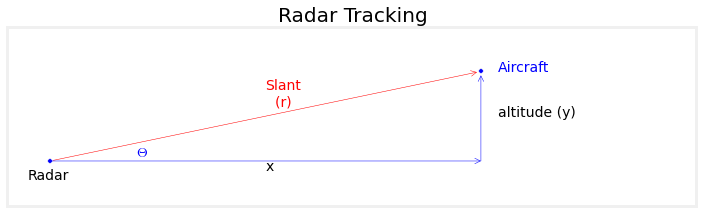

In [4]:
import ekf_internal
ekf_internal.show_radar_chart()

This gives us the equality $x=\sqrt{slant^2 - altitude^2}$. 

### Design the State Variables

We want to track the position of an aircraft assuming a constant velocity and altitude, and measurements of the slant distance to the aircraft. That means we need 3 state variables - horizontal distance, horizonal velocity, and altitude:

$$\mathbf x = \begin{bmatrix}\mathtt{distance} \\\mathtt{velocity}\\ \mathtt{altitude}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

### Design the Process Model

We assume a Newtonian, kinematic system for the aircraft. We've used this model in previous chapters, so by inspection you may recognize that we want

$$\mathbf F = \begin{bmatrix}1 & \Delta t & 0\\
0 & 1 & 0 \\
0 & 0 & 1\end{bmatrix}$$

However, let's practice finding these matrix for a nonlinear system. Please review the section *Modeling a Dynamic System that Has Noise* in the **Kalman Filter Math** chapter if you cannot follow this presentation.

We model nonlinear systems with a set of differential equations. We need an equation in the form 

$$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{w}$$

where $\mathbf{w}$ is the system noise. 

The variables $x$ and $y$ are independent so we can compute them separately. The differential equations for motion in one dimension are:

$$\begin{aligned}v &= \dot x \\
a &= \ddot{x} = 0\end{aligned}$$

Now we put the differential equations into state-space form. If this was a second or greater order differential system we would have to first reduce them to an equivalent set of first degree equations. The equations are first order, so we put them in state space matrix form as

$$\begin{bmatrix}\dot x \\ \ddot{x}\end{bmatrix} =\begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ \dot x\end{bmatrix}$$


We let $\mathbf F=\begin{bmatrix}0&1\\0&0\end{bmatrix}$ and solve the following Taylor series expansion to linearize the equations at $t$:

$$\Phi(t) = e^{\mathbf Ft} = \mathbf{I} + \mathbf Ft  + \frac{(\mathbf Ft)^2}{2!} + \frac{(\mathbf Ft)^3}{3!} + ... $$


$\mathbf F^2 = \begin{bmatrix}0&0\\0&0\end{bmatrix}$, so all higher powers of $\mathbf F$ are also $\mathbf{0}$. Thus the Taylor series expansion is:

$$
\begin{aligned}
\Phi(t) &=\mathbf{I} + \mathbf Ft + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}t\\
&= \begin{bmatrix}1&t\\0&1\end{bmatrix}
\end{aligned}$$

We are trying to find the state transition function for

$$\mathbf x(t_k) = \Phi(t_k-t_{k-1})\mathbf x(t_{k-1})$$ 

If we define $\Delta t = t_k-t_{k-1}$ and substitute it for $t$ in the equation above we get

$$
\begin{aligned}
x(t_k) &= \Phi(\Delta t)x(t_{k-1}) \\
\mathbf{\overline x} &= \Phi(\Delta t)\mathbf x \\
\mathbf{\overline x} &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}\mathbf x \\
\overline{\begin{bmatrix}x \\ \dot x\end{bmatrix}} &=\begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}\begin{bmatrix}x \\ \dot x\end{bmatrix}
\end{aligned}$$

This is the same result used by the kinematic equations! This exercise was unnecessary other than to illustrate linearizing differential equations. Subsequent examples will require you to use these techniques. 

### Design the Measurement Model

The measurement function for our filter needs to take the filter state $\mathbf x$ and turn it into a measurement, which is the slant range distance. We use the Pythagorean theorem to derive

$$h(\mathbf x) = \sqrt{x_{pos}^2 + x_{alt}^2}$$

The relationship between the slant distance and the position on the ground is nonlinear due to the square root term. To use it in the EKF we must linearize it. As we discussed above, the best way to linearize an equation at a point is to find its slope, which we do by taking its derivative.

$$
\mathbf H \equiv \frac{\partial{h}}{\partial{x}}\biggr|_x 
$$

The derivative of a matrix is called a Jacobian, which in general takes the form 

$$\frac{\partial \mathbf H}{\partial \mathbf x} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$

In other words, each element in the matrix is the partial derivative of the function $h$ with respect to the variables $x$. For our problem we have

$$\mathbf H = \begin{bmatrix}\frac{\partial h}{\partial x_{pos}} & \frac{\partial h}{\partial x_{vel}} & \frac{\partial h}{\partial x_{alt}}\end{bmatrix}$$

where $h(x) = \sqrt{x_{pos}^2 + x_{alt}^2}$ as given above.

Solving each in turn:

$$\begin{aligned}
\frac{\partial h}{\partial x_{pos}} &=\frac{\partial}{\partial x_{pos}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ &= \frac{x_{pos}}{\sqrt{x^2 + x_{alt}^2}}
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial x_{vel}} &=
\frac{\partial}{\partial x_{vel}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ 
&= 0
\end{aligned}$$

and

$$\begin{aligned}
\frac{\partial h}{\partial x_{alt}} &= \frac{\partial}{\partial x_{alt}} \sqrt{x_{pos}^2 + x_{alt}^2} \\ &= \frac{x_{alt}}{\sqrt{x_{pos}^2 + x_{alt}^2}}
\end{aligned}$$

giving us 

$$\mathbf H = 
\begin{bmatrix}
\frac{x_{pos}}{\sqrt{x_{pos}^2 + x_{alt}^2}} & 
0 &
&
\frac{x_{alt}}{\sqrt{x_{pos}^2 + x_{alt}^2}}
\end{bmatrix}$$

This may seem daunting, so step back and recognize that all of this math is doing something very simple. We have an equation for the slant range to the airplane which is nonlinear. The Kalman filter only works with linear equations, so we need to find a linear equation that approximates $\mathbf H$. As we discussed above, finding the slope of a nonlinear equation at a given point is a good approximation. For the Kalman filter, the 'given point' is the state variable $\mathbf x$ so we need to take the derivative of the slant range with respect to $\mathbf x$. 

To make this more concrete, let's now write a Python function that computes the Jacobian of $\mathbf H$ for this problem. The `ExtendedKalmanFilter` class will be using this to generate `ExtendedKalmanFilter.H` at each step of the process.

In [5]:
from math import sqrt
def HJacobian_at(x):
    """ compute Jacobian of H matrix for state x """

    horiz_dist = x[0]
    altitude   = x[2]
    denom = sqrt(horiz_dist**2 + altitude**2)
    return array ([[horiz_dist/denom, 0., altitude/denom]])

Finally, let's provide the code for $h(\mathbf x)$

In [6]:
def hx(x):
    """ compute measurement for slant range that
    would correspond to state x.
    """
    
    return (x[0]**2 + x[2]**2) ** 0.5

Now lets write a simulation for our radar.

In [7]:
from numpy.random import randn
import math

class RadarSim(object):
    """ Simulates the radar signal returns from an object
    flying at a constant altityude and velocity in 1D. 
    """
    
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        
    def get_range(self):
        """ Returns slant range to the object. Call once 
        for each new measurement at dt time from last call.
        """
        
        # add some process noise to the system
        self.vel = self.vel  + .1*randn()
        self.alt = self.alt + .1*randn()
        self.pos = self.pos + self.vel*self.dt
    
        # add measurement noise
        err = self.pos * 0.05*randn()
        slant_dist = math.sqrt(self.pos**2 + self.alt**2)
        
        return slant_dist + err

### Design Process and Measurement Noise

The radar returns the range distance. A good radar can achieve accuracy of $\sigma_{range}= 5$ meters, so we will use that value. This gives us

$$\mathbf R = \begin{bmatrix}\sigma_{range}^2\end{bmatrix} = \begin{bmatrix}25\end{bmatrix}$$


The design of $\mathbf Q$ requires some discussion. The state $\mathbf x= \begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$. The first two elements are position (down range distance) and velocity, so we can use `Q_discrete_white_noise` noise to compute the values for the upper left hand side of $\mathbf Q$. The third element of  $\mathbf x$ is altitude, which we are assuming is independent of the down range distance. That leads us to a block design of $\mathbf Q$ of:

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & 0 \\ 0 & \mathbf Q_\mathtt{y}\end{bmatrix}$$


### Implementation

The `FilterPy` library provides the class `ExtendedKalmanFilter`. It works very similar to the `KalmanFilter` class we have been using, except that it allows you to provide functions that compute the Jacobian of $\mathbf H$ and the function $h(\mathbf x)$. We have already written the code for these two functions, so let's get going.

We start by importing the filter and creating it. There are 3 variables in `x` and only 1 measurement. At the same time we will create our radar simulator.

```python
from filterpy.kalman import ExtendedKalmanFilter

rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)
```

We will initialize the filter near the airplane's actual position

```python
rk.x = array([radar.pos, radar.vel-10, radar.alt+100])
```

We assign the system matrix using the first term of the Taylor series expansion we computed above.

```python
dt = 0.05
rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]])*dt
```

After assigning reasonable values to $\mathbf R$, $\mathbf Q$, and $\mathbf P$ we can run the filter with a simple loop

```python
for i in range(int(20/dt)):
    z = radar.get_range()
    rk.update(array([z]), HJacobian_at, hx)
    rk.predict()
```

Putting that all together along with some boilerplate code to save the results and plot them, we get

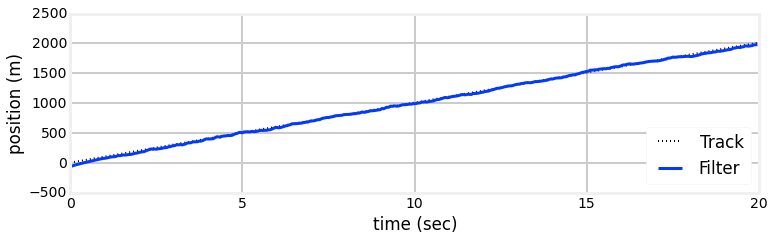

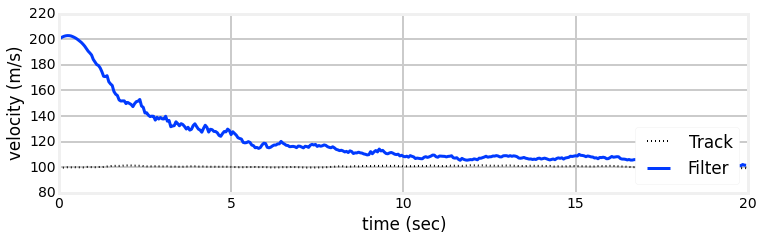

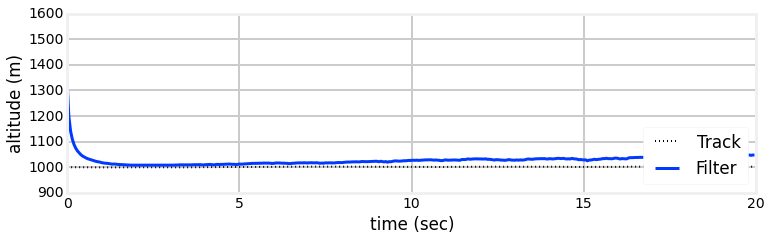

In [8]:
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import ExtendedKalmanFilter
from numpy import eye, array, asarray

dt = 0.05
rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)

# make an imperfect starting guess
rk.x = array([radar.pos-100, radar.vel+100, radar.alt+1000])

rk.F = array([[1, dt, 0],
              [0, 1, 0],
              [0, 0, 1]])

range_std = 5. # meters
rk.R = np.diag([range_std**2])
rk.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
rk.Q[2,2] = 0.1
rk.P *= 50

xs, track = [], []
for i in range(int(20/dt)):
    z = radar.get_range()
    track.append((radar.pos, radar.vel, radar.alt))
    
    rk.update(array([z]), HJacobian_at, hx)
    xs.append(rk.x)
    rk.predict()

xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)
ekf_internal.plot_radar(xs, track, time)

## Using SymPy to compute Jacobians

Depending on your experience with derivatives you may have found the computation of the Jacobian above either fairly straightforward, or quite difficult. Even if you found it easy, a slightly more difficult problem easily leads to very difficult computations.

As explained in Appendix A, we can use the SymPy package to compute the Jacobian for us. 

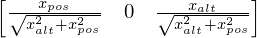

In [9]:
import sympy
sympy.init_printing()

x_pos, x_vel, x_alt = sympy.symbols('x_pos, x_vel x_alt')

H = sympy.Matrix([sympy.sqrt(x_pos**2 + x_alt**2)])

state = sympy.Matrix([x_pos, x_vel, x_alt])
H.jacobian(state)

This result is the same as the result we computed above, and with much less effort on our part!

## Robot Localization

So, time to try a real problem. I warn you that this is far from a simple problem. However, most books choose simple, textbook problems with simple answers, and you are left wondering how to implement a real world solution. 

We will consider the problem of robot localization. We already implemented this in the **Unscented Kalman Filter** chapter, and I recommend you read that first. In this scenario we have a robot that is moving through a landscape with sensors that give range and bearings to various landmarks. This could be a self driving car using computer vision to identify trees, buildings, and other landmarks. It might be one of those small robots that vacuum your house, or a robot in a warehouse.

Our robot has 4 wheels configured the same as an automobile. It maneuvers by pivoting the front wheels. This causes the robot to pivot around the rear axle while moving forward. This is nonlinear behavior which we will have to model. 

The robot has a sensor that gives it approximate range and bearing to known targets in the landscape. This is nonlinear because computing a position from  a range and bearing requires square roots and trigonometry. 

Both the process model and measurement models are nonlinear. The UKF accommodates both, so we provisionally conclude that the UKF is a viable choice for this problem.

### Robot Motion Model

At a first approximation an automobile steers by pivoting the front tires while moving forward. The front of the car moves in the direction that the wheels are pointing while pivoting around the rear tires. This simple description is complicated by issues such as slippage due to friction, the differing behavior of the rubber tires at different speeds, and the need for the outside tire to travel a different radius than the inner tire. Accurately modeling steering requires a complicated set of differential equations. 

For Kalman filtering, especially for lower speed robotic applications a simpler *bicycle model* has been found to perform well. This is a depiction of the model:

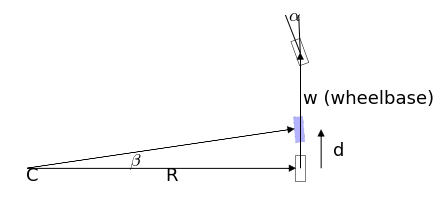

In [10]:
ekf_internal.plot_bicycle()

Here we see the front tire is pointing in direction $\alpha$ relative to the wheelbase. Over a short time period the car moves forward and the rear wheel ends up further ahead and slightly turned inward, as depicted with the blue shaded tire. Over such a short time frame we can approximate this as a turn around a radius $R$. We can compute the turn angle $\beta$ with

$$\beta = \frac{d}{w} \tan{(\alpha)}$$

and the turning radius R is given by 

$$R = \frac{d}{\beta}$$

where the distance the rear wheel travels given a forward velocity $v$ is $d=v\Delta t$.

If we let $\theta$ be our current orientation then we can compute the position $C$ before the turn starts as

$$ C_x = x - R\sin(\theta) \\
C_y = y + R\cos(\theta)
$$

After the move forward for time $\Delta t$ the new position and orientation of the robot is

$$\begin{aligned} x &= C_x + R\sin(\theta + \beta) \\
y &= C_y - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

Once we substitute in for $C$ we get

$$\begin{aligned} x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

You do not need to understand this math in detail if you are not interested in steering models. The important thing to recognize is that our motion model is nonlinear, and we will need to deal with that with our Kalman filter.

### Design the State Variables

For our robot we will maintain the position and orientation of the robot:

$$\mathbf x = \begin{bmatrix}x \\ y \\ \theta\end{bmatrix}$$

Our control input $\mathbf u$ is the velocity and steering angle

$$\mathbf u = \begin{bmatrix}v \\ \alpha\end{bmatrix}$$

### Design the System Model

In general we model our system as a nonlinear motion model plus noise.

$$\overline x = x + f(x, u) + \mathcal{N}(0, Q)$$

Using the motion model for a robot that we created above, we can expand this to

$$\overline{\begin{bmatrix}x\\y\\\theta\end{bmatrix}} = \begin{bmatrix}x\\y\\\theta\end{bmatrix} + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}$$

We linearize this with a taylor expansion at $x$:

$$f(x, u) \approx \mathbf x + \frac{\partial f(\mathbf x, \mathbf u)}{\partial x}\biggr|_{\mathbf x, \mathbf u} $$

We replace $f(x, u)$ with our state estimate $\mathbf x$, and the derivative is the Jacobian of $f$.

The Jacobian $\mathbf F$ is

$$\mathbf F = \frac{\partial f(x, u)}{\partial x} =\begin{bmatrix}
\frac{\partial \dot x}{\partial x} & 
\frac{\partial \dot x}{\partial y} &
\frac{\partial \dot x}{\partial \theta}\\
\frac{\partial \dot y}{\partial x} & 
\frac{\partial \dot y}{\partial y} &
\frac{\partial \dot y}{\partial \theta} \\
\frac{\partial \dot{\theta}}{\partial x} & 
\frac{\partial \dot{\theta}}{\partial y} &
\frac{\partial \dot{\theta}}{\partial \theta}
\end{bmatrix}
$$

When we calculate these we get

$$\mathbf F = \begin{bmatrix}
1 & 0 & -R\cos(\theta) + R\cos(\theta+\beta) \\
0 & 1 & -R\sin(\theta) + R\sin(\theta+\beta) \\
0 & 0 & 1
\end{bmatrix}$$

We can double check our work with SymPy.

In [11]:
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
sympy.init_printing(use_latex="mathjax", fontsize='16pt')
time = symbols('t')
d = v*time
beta = (d/w)*sympy.tan(alpha)
r = w/sympy.tan(alpha)

fxu = Matrix([[x-r*sympy.sin(theta) + r*sympy.sin(theta+beta)],
              [y+r*sympy.cos(theta)- r*sympy.cos(theta+beta)],
              [theta+beta]])
J = fxu.jacobian(Matrix([x, y, theta]))
J

⎡                        ⎛t⋅v⋅tan(α)    ⎞⎤
⎢                   w⋅cos⎜────────── + θ⎟⎥
⎢        w⋅cos(θ)        ⎝    w         ⎠⎥
⎢1  0  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎢                        ⎛t⋅v⋅tan(α)    ⎞⎥
⎢                   w⋅sin⎜────────── + θ⎟⎥
⎢        w⋅sin(θ)        ⎝    w         ⎠⎥
⎢0  1  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎣0  0                  1                 ⎦

That looks a bit complicated. We can use SymPy to substitute terms:

In [12]:
# reduce common expressions
B, R = symbols('beta, R')
J = J.subs((d/w)*sympy.tan(alpha), B)
J.subs(w/sympy.tan(alpha), R)

⎡1  0  -R⋅cos(θ) + R⋅cos(β + θ)⎤
⎢                              ⎥
⎢0  1  -R⋅sin(θ) + R⋅sin(β + θ)⎥
⎢                              ⎥
⎣0  0             1            ⎦

In that form we can see that our computation of the Jacobian is correct.

Now we can turn our attention to the noise. Here, the noise is in our control input, so it is in *control space*. In other words, we command a specific velocity and steering angle, but we need to convert that into errors in $x, y, \theta$. In a real system this might vary depending on velocity, so it will need to be recomputed for every prediction. I will choose this as the noise model; for a real robot you will need to choose a model that accurately depicts the error in your system. 

$$\mathbf{M} = \begin{bmatrix}\sigma_{vel}^2 & 0 \\ 0 & \sigma_\alpha^2\end{bmatrix}$$

If this was a linear problem we would convert from control space to state space using the by now familiar $\mathbf{FMF}^\mathsf T$ form. Since our motion model is nonlinear we do not try to find a closed form solution to this, but instead linearize it with a Jacobian which we will name $\mathbf{V}$. 

$$\mathbf{V} = \frac{\partial f(x, u)}{\partial u} \begin{bmatrix}
\frac{\partial \dot x}{\partial v} & \frac{\partial \dot x}{\partial \alpha} \\
\frac{\partial \dot y}{\partial v} & \frac{\partial \dot y}{\partial \alpha} \\
\frac{\partial \dot{\theta}}{\partial v} & \frac{\partial \dot{\theta}}{\partial \alpha}
\end{bmatrix}$$

These partial derivatives become very difficult to work with. Let's compute them with SymPy. 

In [13]:
V = fxu.jacobian(Matrix([v, alpha]))
V = V.subs(sympy.tan(alpha)/w, 1/R) 
V = V.subs(time*v/R, B)
V = V.subs(time*v, 'd')
V

⎡                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅cos(β + θ)   w⋅⎝- tan (α) - 1⎠⋅sin(θ)   w⋅⎝- ta
⎢t⋅cos(β + θ)  ────────────────────────── - ──────────────────────── + ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅sin(β + θ)   w⋅⎝- tan (α) - 1⎠⋅cos(θ)   w⋅⎝- ta
⎢t⋅sin(β + θ)  ────────────────────────── + ──────────────────────── - ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                                                  ⎛

This should give you an appreciation of how quickly the EKF become mathematically intractable. 

This gives us the final form of our prediction equations:

$$\begin{aligned}
\mathbf{\overline x} &= \mathbf x + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}\\
\mathbf{\overline P} &=\mathbf{FPF}^{\mathsf T} + \mathbf{VMV}^{\mathsf T}
\end{aligned}$$

One final point. This form of linearization is not the only way to predict $\mathbf x$. For example, we could use a numerical integration technique like *Runge Kutta* to compute the position of the robot in the future. In fact, if the time step is relatively large you will have to do that. As I am sure you are realizing, things are not as cut and dried with the EKF as it was for the KF. For a real problem you have to very carefully model your system with differential equations and then determine the most appropriate way to solve that system. The correct approach depends on the accuracy you require, how nonlinear the equations are, your processor budget, and numerical stability concerns. These are all topics beyond the scope of this book.

### Design the Measurement Model

Now we need to design our measurement model. For this problem we are assuming that we have a sensor that receives a noisy bearing and range to multiple known locations in the landscape. The measurement model must convert the state $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf T$ into a range and bearing to the landmark. Using $p$ be the position of a landmark, the range $r$ is

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

We assume that the sensor provides bearing relative to the orientation of the robot, so we must subtract the robot's orientation from the bearing to get the sensor reading, like so:

$$\phi = \arctan(\frac{p_y - y}{p_x - x}) - \theta$$


Thus our function is


$$\begin{aligned}
\mathbf x& = h(x,p) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\arctan(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

This is clearly nonlinear, so we need linearize $h(x, p)$  at $\mathbf x$ by taking its Jacobian. We compute that with SymPy below.

In [14]:
px, py = symbols('px, py')
z = Matrix([[sympy.sqrt((px-x)**2 + (py-y)**2)],
            [sympy.atan2(py-y, px-x) - theta]])
z.jacobian(Matrix([x, y, theta]))

⎡         -px + x                     -py + y              ⎤
⎢──────────────────────────  ──────────────────────────  0 ⎥
⎢   _______________________     _______________________    ⎥
⎢  ╱         2           2     ╱         2           2     ⎥
⎢╲╱  (px - x)  + (py - y)    ╲╱  (px - x)  + (py - y)      ⎥
⎢                                                          ⎥
⎢       -(-py + y)                   -(px - x)             ⎥
⎢  ─────────────────────       ─────────────────────     -1⎥
⎢          2           2               2           2       ⎥
⎣  (px - x)  + (py - y)        (px - x)  + (py - y)        ⎦

Now we need to write that as a Python function. For example we might write:

In [15]:
from math import sqrt

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)

    H = array(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

We also need to define a function that converts the system state into a measurement.

In [16]:
from math import atan2
def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = array([[dist],
                [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

### Design Measurement Noise

This is quite straightforward as we need to specify measurement noise in measurement space, hence it is linear. It is reasonable to assume that the range and bearing measurement noise is independent, hence

$$R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

### Implementation

We will use `FilterPy`'s `ExtendedKalmanFilter` class to implement the filter. Its `predict()` method uses the standard linear equations. Our process model is nonlinear, so we will have to override `predict()` with our own version.  I'll want to also use this class to simulate the robot, so I'll add a method `move()` that computes the position of the robot which both `predict()` and my simulation can call.

The matrices for the prediction step are quite large. While writing this code I made several errors before I finally got it working. I only found my errors by using SymPy's `evalf` function, which allows you to evaluate a SymPy `Matrix` with specific values for the variables. I decided to demonstrate this technique, and to eliminate a possible source of bugs, by using SymPy in the Kalman filter. You'll need to understand a couple of points.

First, `evalf` uses a dictionary to pass in the values you want to use. For example, if your matrix contains an `x` and `y`, you can write

```python
    M.evalf(subs={x:3, y:17})
```
    
to evaluate the matrix for `x=3` and `y=17`. 

Second, `evalf` returns a `sympy.Matrix` object. Use `numpy.array(M).astype(float)` to convert it to a NumPy array. `numpy.array(M)` creates an array of  type `object`, which is not what you want.

Here is the code for the EKF:

In [36]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import dot, array, sqrt
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        a, x, y, v, w, theta, time = symbols(
            'a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
    
        self.fxu = Matrix(
            [[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
             [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
             [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, 
                     time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u=0):
        self.x = self.move(self.x, u, self.dt)

        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel*u[0]**2, 0], 
                   [0, self.std_steer**2]])

        self.P = dot(F, self.P).dot(F.T) + dot(V, M).dot(V.T)

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius

            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)], 
                           [r*cos(hdg) - r*cos(hdg + beta)], 
                           [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)], 
                           [dist*sin(hdg)], 
                           [0]])
        return x + dx

Now we have another issue to handle. The residual is notionally computed as $y = z - h(x)$ but this will not work because our measurement contains an angle in it. Suppose z has a bearing of $1^\circ$ and $h(x)$ has a bearing of $359^\circ$. Naively subtracting them would yield a bearing difference of $-358^\circ$, which will throw off the computation of the Kalman gain. The correct angle difference in this case is $2^\circ$. So we will have to write code to correctly compute the bearing residual.

In [33]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing 
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[1] > np.pi:          # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y

The rest of the code runs the simulation and plots the results, and shouldn't need too much comment by now. I create a variable `landmarks` that contains the coordinates of the landmarks. I update the simulated robot position 10 times a second, but run the EKF only once. This is for two reasons. First, we are not using Runge Kutta to integrate the differental equations of motion, so a narrow time step allows our simulation to be more accurate. Second, it is fairly normal in embedded systems to have limited processing speed. This forces you to run your Kalman filter only as frequently as absolutely needed.

In [107]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
dt = 1.0


def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + randn()*std_rng],
                  [a + randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian=H_of, Hx=Hx, 
               residual=residual,
               args=(landmark), hx_args=(landmark))
    
                
def run_localization(landmarks, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=10, ellipse_step=20, ylim=None):
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = array([[2, 6, .3]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = array([1.1, .01]) 

    plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60)
    
    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='k', alpha=0.3)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = z_landmark(lmark, sim_pos,
                               std_range, std_bearing)
                ekf_update(ekf, z, lmark)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
                    std=6, facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

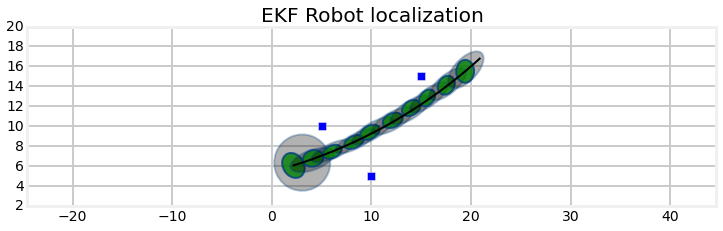

Final P: [ 0.025  0.041  0.002]


In [108]:
landmarks = array([[5, 10], [10, 5], [15, 15]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())

I have plotted the landmarks as solid squares. The path of the robot is drawn with black line. The covariance ellipses for the predict step is light gray, and the covariances of the update are shown in green. To make them visible at this scale I have set the ellipse boundary at 6$\sigma$.

From this we can see that there is a lot of uncertainty added by our motion model, and that most of the error in in the direction of motion. We can see that from the shape of the blue ellipses. After a few steps we can see that the filter incorporates the landmark measurements.

I used the same initial conditions and landmark locations in the UKF chapter. You can see both in the plot and in the printed final value for $\mathbf P$ that the UKF achieves much better accuracy in terms of the error ellipse. The black solid line denotes the robot's actual path. Both perform roughly as well as far as their estimate for $\mathbf x$ is concerned. 

Now lets add another landmark.

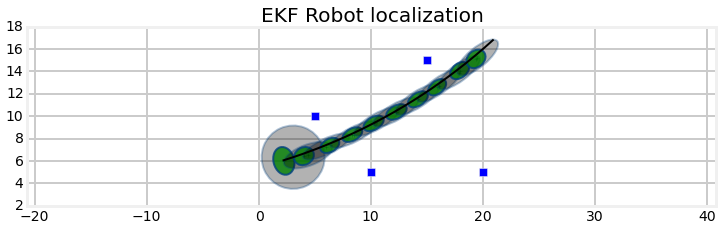

Final P: [ 0.021  0.02   0.002]


In [109]:
landmarks = array([[5, 10], [10, 5], [15, 15], [20, 5]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
plt.show()
print('Final P:', ekf.P.diagonal())

The uncertainly in the estimates near the end of the track are smaller with the additional landmark.  We can see the fantastic effect that multiple landmarks has on our uncertainty by only using the first two landmarks.

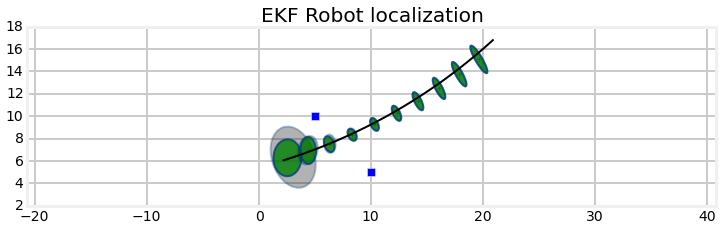

Final P: [ 0.018  0.046  0.   ]


In [110]:
ekf = run_localization(
    landmarks[0:2], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

The estimate quickly diverges from the robot's path after passing the landmarks. The covariance also grows quickly. Let's see what happens with only one landmark:

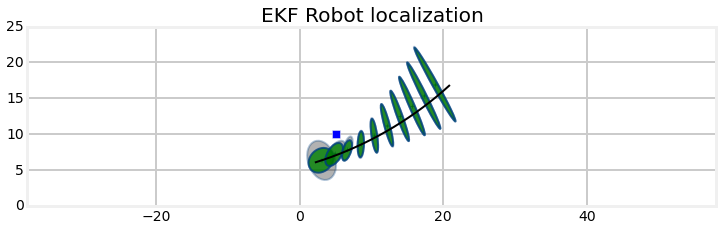

Final P: [ 0.276  0.809  0.004]


In [111]:
ekf = run_localization(
    landmarks[0:1], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

As you probably suspected, only one landmark produces a very bad result. Conversely, a large number of landmarks allows us to make very accurate estimates.

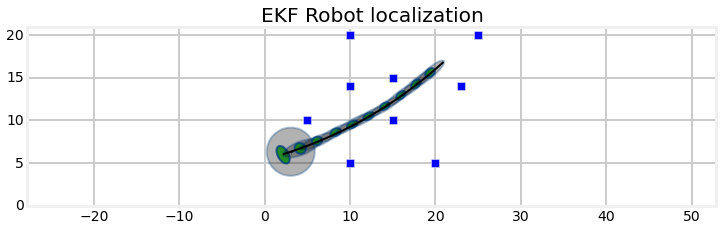

Final P: [ 0.008  0.009  0.001]


In [115]:
landmarks = array([[5, 10], [10,  5], [15, 15], [20,  5], [15, 10], 
                   [10,14], [23, 14], [25, 20], [10, 20]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1, ylim=(0, 21))
print('Final P:', ekf.P.diagonal())

### Discussion

I said that this was a 'real' problem, and in some ways it is. I've seen alternative presentations that used robot motion models that led to much easier Jacobians. On the other hand, my model of a automobile's movement is itself simplistic in several ways. First, it uses a bicycle model. A real car has two sets of tires, and each travels on a different radius. The wheels do not grip the surface perfectly. I also assumed that the robot responds instantaneously to the control input. Sebastian Thrun writes in *Probabilistic Robots* that simplified models are justified because the filters perform well when used to track real vehicles. The lesson here is that while you have to have a reasonably accurate nonlinear model, it does not need to be perfect to operate well. As a designer you will need to balance the fidelity of your model with the difficulty of the math and the computation required to implement the equations. 

Another way in which this problem was simplistic is that we assumed that we knew the correspondance between the landmarks and measurements. But suppose we are using radar - how would we know that a specific signal return corresponded to a specific building in the local scene? This question hints at SLAM algorithms - simultaneous localization and mapping. SLAM is not the point of this book, so I will not elaborate on this topic. 

## UKF vs EKF

I implemented this tracking problem using the UKF in the previous chapter. The difference in implementation should be very clear. Computing the Jacobians for the state and measurement models was not trivial despite a rudimentary motion model. I am justified in using this model because the research resulting from the DARPA car challenges has shown that it works well in practice. A different problem could result in a Jacobian which is difficult or impossible to derive analytically. In contrast, the UKF only requires you to provide a function that computes the system motion model and another for the measurement model. 

There are many cases where the Jacobian cannot be found analytically. The details are beyond the scope of this book, but you will have to use numerical methods to compute the Jacobian. That is a very nontrivial undertaking, and you will spend a significant portion of a master's degree at a STEM school learning techniques to handle such situations. Even then you'll likely only be able to solve problems related to your field - an aeronautical engineer learns a lot about Navier Stokes equations, but not much about modelling chemical reaction rates. 

So, UKFs are easy. Are they accurate? In practice they often perform better than the EKF. You can find plenty of research papers that prove that the UKF outperforms the EKF in various problem domains. It's not hard to understand why this would be true. The EKF works by linearizing the system model and measurement model at a single point, and the UKF uses $2n+1$ points.

Let's look at a specific example. Take $f(x) = x^3$ and pass a Gaussian distribution through it. I will compute an accurate answer using a monte carlo simulation. I generate 50,000 points randomly distributed according to the Gaussian, pass each through $f(x)$, then compute the mean and variance of the result. 

First, let's see how the EKF fairs. The EKF linearizes the function by taking the derivative and evaluating it the mean $x$ to get the slope tangent to the function at that point. This slope becomes the linear function that we use to transform the Gaussian. Here is a plot of that.

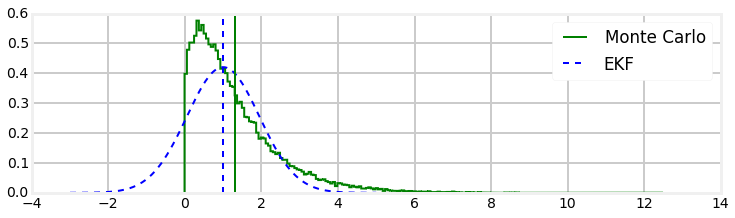

actual mean=1.30, std=1.14
EKF    mean=1.00, std=0.95


In [117]:
import nonlinear_plots
nonlinear_plots.plot_ekf_vs_mc()

We can see from both the graph and the print out at the bottom that the EKF has introduced quite a bit of error.

In contrast, here is the performance of the UKF:

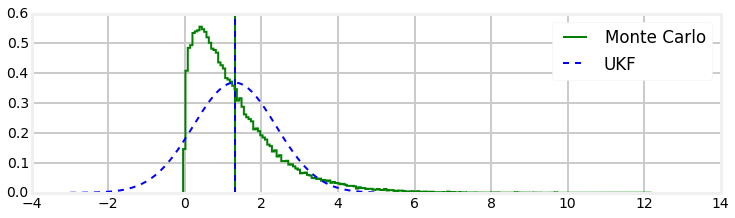

actual mean=1.30, std=1.13
UKF    mean=1.30, std=1.08


In [119]:
nonlinear_plots.plot_ukf_vs_mc(alpha=0.001, beta=3., kappa=1.)

Here we can see that the computation of the UKF's mean is accurate to 2 decimal places. The standard deviation is slightly off, but you can also fine tune how the UKF computes the distribution by using the $\alpha$, $\beta$, and $\gamma$ parameters for generating the sigma points. Here I used $\alpha=0.001$, $\beta=3$, and $\gamma=1$. Feel free to modify them in the function call to see the result. You should be able to get better results than I did. However, avoid over-tuning the UKF for a specific test. It may perform better for your test case, but worse in general.

This is a contrived example, but as I said the literature is filled with detailed studies of real world problems that exhibit similar performance differences between the two filters.